In [2]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


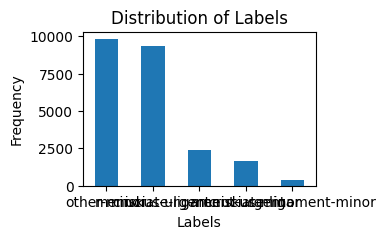

In [3]:
data_label = "data2"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

In [4]:
df_train["data2"].iloc[0]

'. Mein linkes Knie kann nicht überstreckt werden und ich habe ein Streckdefizit. Die Beugung des Knies ist gut möglich. Mein Knie hat keine Schwellung. Es gibt einen deutlichen Druckschmerz auf der inneren Seite des Kniegelenks, aber keinen Druckschmerz auf der äußeren Seite des Kniegelenks.'

# Model parameters

In [3]:
model_name = "baseline"

In [5]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

2024-08-06 08:44:10.941592: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-06 08:44:10.941616: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-06 08:44:10.941621: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-06 08:44:10.941638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-06 08:44:10.941649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model definition and training

In [6]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [7]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/15


2024-08-06 08:44:15.755539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


736/736 ━━━━━━━━━━━━━━━━━━━━ 137s 183ms/step - accuracy: 0.4529 - auc: 0.8050 - f1_score: 0.2376 - loss: 1.1853 - val_accuracy: 0.5263 - val_auc: 0.8410 - val_f1_score: 0.3065 - val_loss: 1.0970
Epoch 2/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 134s 182ms/step - accuracy: 0.5912 - auc: 0.8711 - f1_score: 0.3954 - loss: 0.9988 - val_accuracy: 0.5510 - val_auc: 0.8514 - val_f1_score: 0.3631 - val_loss: 1.0808
Epoch 3/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 133s 181ms/step - accuracy: 0.6662 - auc: 0.9128 - f1_score: 0.5485 - loss: 0.8270 - val_accuracy: 0.5854 - val_auc: 0.8660 - val_f1_score: 0.4267 - val_loss: 1.0539
Epoch 4/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 137s 186ms/step - accuracy: 0.7196 - auc: 0.9384 - f1_score: 0.6521 - loss: 0.6942 - val_accuracy: 0.6033 - val_auc: 0.8735 - val_f1_score: 0.4605 - val_loss: 1.0444
Epoch 5/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 135s 184ms/step - accuracy: 0.7520 - auc: 0.9503 - f1_score: 0.6935 - loss: 0.6234 - val_accuracy: 0.6201 - val_auc: 0.8762 - val_f1_score: 0.5032 

246/246 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step


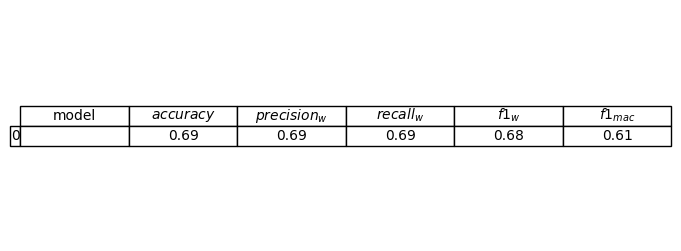

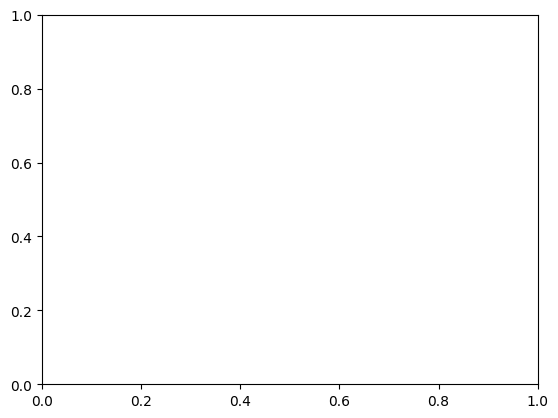

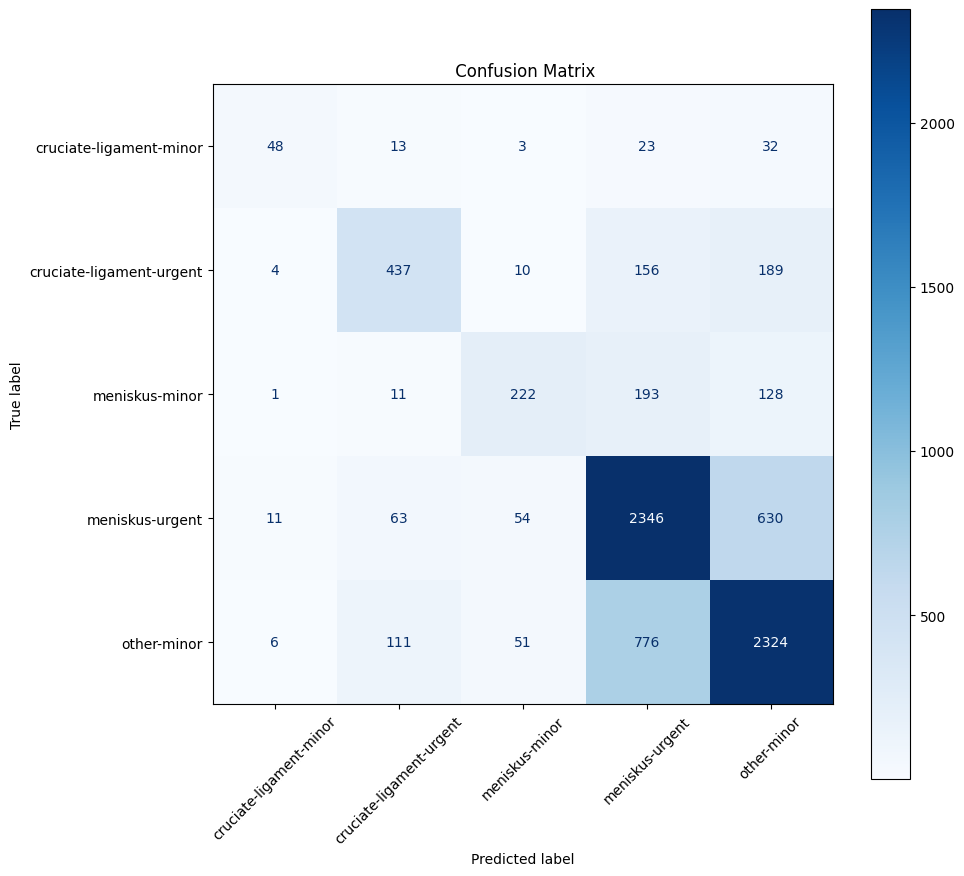

ValueError: Cannot embed the '../reports/lstm/.png' image format

In [8]:
eval(model, test_padded, test_labels, label_encoder)

In [ ]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to ../models/lstm/baseline/baseline.h5
Data saved


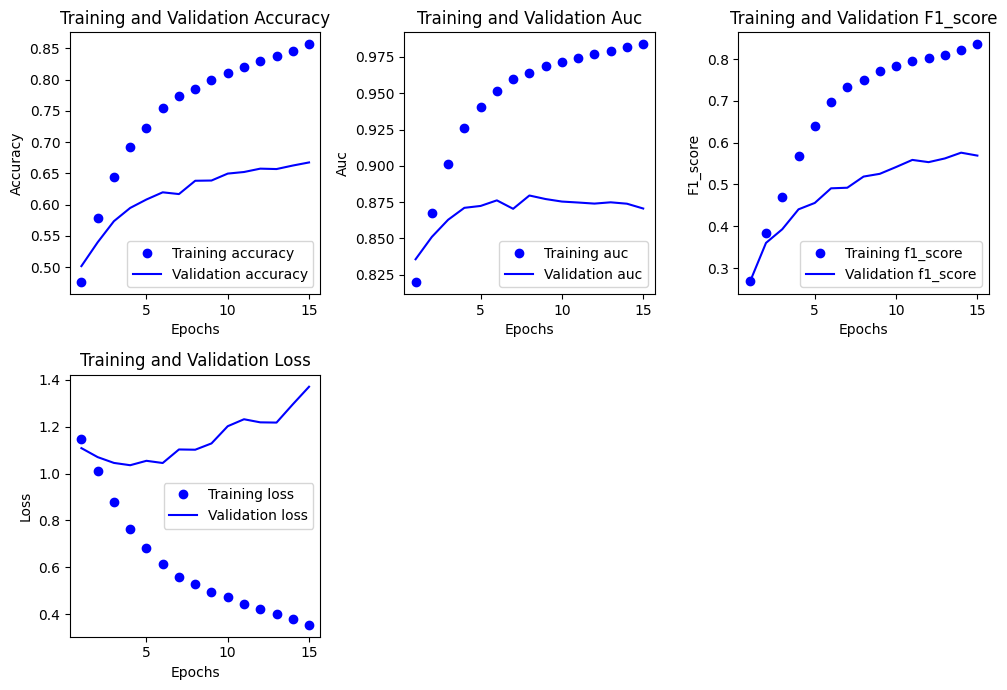

In [ ]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step


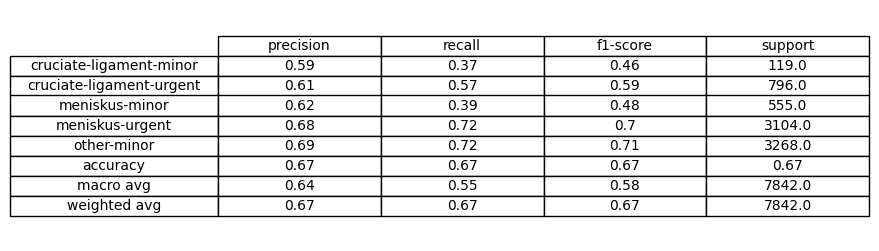

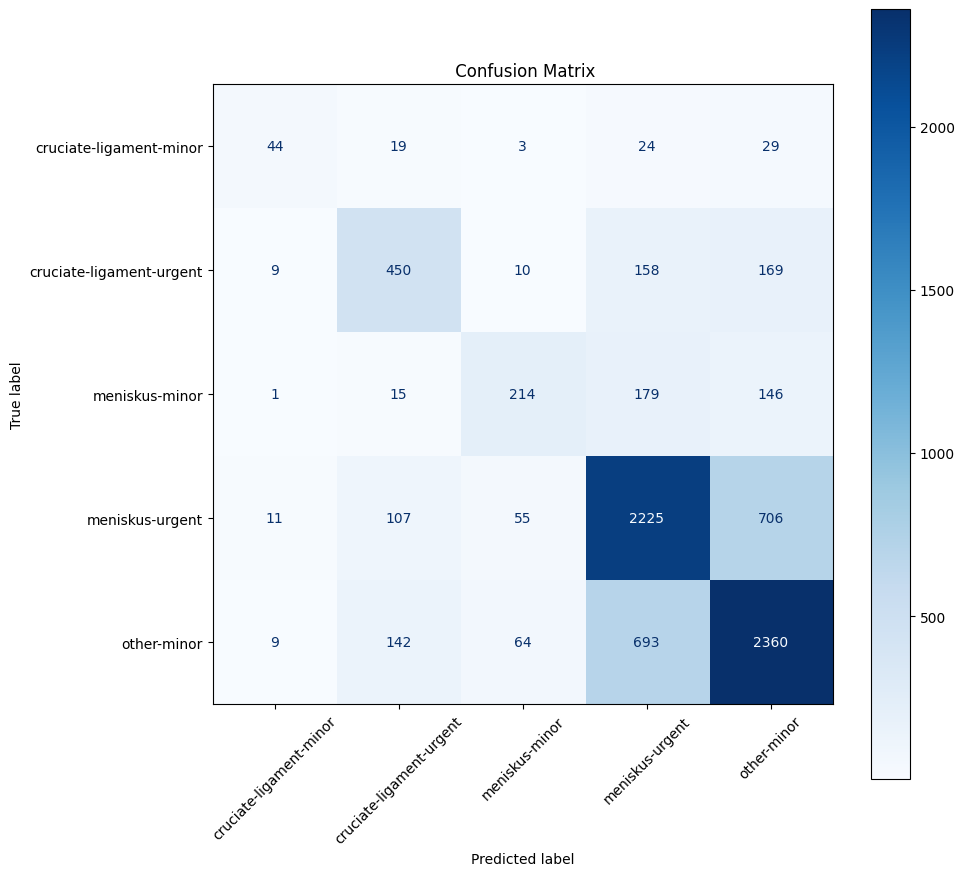

In [ ]:
eval(model, test_padded, test_labels, label_encoder)